In [1]:
import os
os.environ["TF_NUM_THREADS"] = "0" # use all available CPU cores

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import xarray as xr
import pandas as pd
import time

import diffxpy.api as de
from batchglm.api.models.nb_glm import Simulator

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.WARNING)
logging.getLogger("diffxpy").setLevel(logging.WARNING)

logger = logging.getLogger(__name__)


In [2]:
def test_wilcoxon(sim):
    logger.info("test_wilcoxon started")
    start = time.time()
    test = de.test.versus_rest(
        data=sim.X,
        grouping="batch",
        test="wilcoxon",
        sample_description=sim.sample_description,
    )
    end = time.time()
    logger.info("test_wilcoxon finished in %fs", (end - start))

    return test, (end - start)


def test_t_test(sim):
    logger.info("test_t_test started")
    start = time.time()
    test = de.test.versus_rest(
        data=sim.X,
        grouping="batch",
        test="t_test",
        sample_description=sim.sample_description,
    )
    end = time.time()
    logger.info("test_t_test finished in %fs", (end - start))

    return test, (end - start)


def test_lrt(sim):
    logger.info("test_lrt started")
    start = time.time()
    test = de.test.versus_rest(
        data=sim.X,
        grouping="batch",
        test="lrt",
        noise_model="nb",
        sample_description=sim.sample_description,
    )
    end = time.time()
    logger.info("test_lrt finished in %fs", (end - start))

    return test, (end - start)


def test_wald(sim):
    logger.info("test_wald started")
    start = time.time()
    test = de.test.versus_rest(
        data=sim.X,
        grouping="batch",
        test="wald",
        noise_model="nb",
        sample_description=sim.sample_description,
    )
    end = time.time()
    logger.info("test_wald finished in %fs", (end - start))

    return test, (end - start)




In [3]:
df = pd.DataFrame(columns=[
    "n_groups",
    "n_cells",
    "n_genes",
    "wilcoxon",
    "t_test",
    # "lrt",
    "wald",
])

n_groups = 4
n_genes = 1000
for n_cells in (1e3, 1e4, 1e5):
    n_cells = int(n_cells)
    logger.info("Running tests with n_cells=%d and n_genes=%d", n_cells, n_genes)
    
    sim = Simulator(num_observations=n_cells, num_features=n_genes)
    sim.generate_sample_description(num_batches=n_groups, num_confounders=0)
    sim.generate()

    df = df.append({
        "n_groups": n_groups,
        "n_cells": n_cells,
        "n_genes": n_genes,
        "wilcoxon": test_wilcoxon(sim)[1],
        "t_test": test_t_test(sim)[1],
        # "lrt": test_lrt(sim)[1],
        "wald": test_wald(sim)[1],
    }, ignore_index=True)


Running tests with n_cells=1000 and n_genes=1000
test_wilcoxon started
test_wilcoxon finished in 1.446630s
test_t_test started
test_t_test finished in 0.052015s
test_wald started
test_wald finished in 39.249147s
Running tests with n_cells=10000 and n_genes=1000
test_wilcoxon started
test_wilcoxon finished in 7.162327s
test_t_test started
test_t_test finished in 0.495934s
test_wald started
test_wald finished in 158.093063s
Running tests with n_cells=100000 and n_genes=1000
test_wilcoxon started
test_wilcoxon finished in 77.858433s
test_t_test started
test_t_test finished in 4.672392s
test_wald started
test_wald finished in 1432.336943s


In [4]:
df

,n_groups,n_cells,n_genes,wilcoxon,t_test,wald
0,4.0,1000.0,1000.0,1.446630,0.052015,39.249147
1,4.0,10000.0,1000.0,7.162327,0.495934,158.093063
2,4.0,100000.0,1000.0,77.858433,4.672392,1432.336943


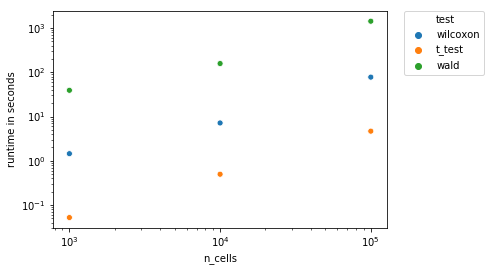

In [5]:
melted = pd.melt(df, id_vars=["n_genes", "n_cells", "n_groups"], var_name="test", value_name="runtime")

fig, ax = plt.subplots()
ax.set(xscale="log", yscale="log")

sns.scatterplot(data=melted, x="n_cells", y="runtime", hue="test", ax=ax)

ax.set(ylabel='runtime in seconds')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()